In [39]:
# python basic pacakages
import aifc
import os
import datetime
from os import listdir
from os.path import isfile, join
import csv

# required packags
import tensorflow as tf
import numpy as np
import pandas as pd

from matplotlib import mlab
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# my packages
from DataManager.Audio import *
from DataManager.General import *

In [30]:
# labels_path = "C:\\Users\\jorge\\DatasetsTFM\\KaggleData\\train.csv"
# train_path = "C:\\Users\\jorge\\DatasetsTFM\\KaggleData\\train"

labels_path = "data/train.csv"
train_path = "data/train"

limitator = 1000

In [31]:
audiofiles = [os.path.join(train_path, f) for f in listdir(train_path) if isfile(join(train_path, f))]

In [32]:
labels_dict = get_labels(labels_path)

# Get a random permutation to remove ordering bias
np.random.shuffle(audiofiles)

# convert the list of files to numpy arrays and select a random smaller version if limitador is not None
X_path = np.array(audiofiles)[:limitator]

# Start the process of data extraction, spectrogram transformation and data enhancement
print('Generating train and test split')
X_train_path, X_test_path = train_test_split(X_path, test_size=0.3)

print('Getting test spectrograms')
X_test, Y_test = get_spects(X_test_path, labels_dict)

print('Getting train spectrograms + enhancement')
X_train, Y_train = get_spects_enhanced(X_train_path, labels_dict)

print('Getting even more data adding noise to whale calls')
X_enhanced, Y_enhanced = enhance_with_noise(X_train, Y_train)

X_train, Y_train = np.concatenate([X_train, X_enhanced]), np.concatenate([Y_train, Y_enhanced])

print('Test', X_test.shape)

print('Train', X_train.shape)


Generating train and test split
Getting test spectrograms
Getting train spectrograms + enhancement
Getting even more data adding noise to whale calls
Test (300, 40, 40)
Train (2598, 40, 40)


In [33]:
print('Test: Whale %d, Not Whale %d' % ((Y_test == '1').sum(), (Y_test == '0').sum()))

print('Train: Whale %d, Not Whale %d' % ((Y_train == '1').sum(), (Y_train == '0').sum()) )

Test: Whale 58, Not Whale 242
Train: Whale 996, Not Whale 1602


In [34]:
'Tamaño en memoria de los datos de training aprox: %.2fGB' % (X_train.nbytes/2**10/2**10/2**10)

'Tamaño en memoria de los datos de training aprox: 0.03GB'

In [35]:
Y_train, Y_test = Y_train.astype(int), Y_test.astype(int)
Y_train, Y_test = tf.keras.utils.to_categorical(Y_train, 2), tf.keras.utils.to_categorical(Y_test, 2) 

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(20, kernel_size=(7, 7), activation=tf.nn.relu, input_shape=X_train.shape[1:], name='Conv1'),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(40, kernel_size=(7, 7), activation=tf.nn.relu, name='Conv2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu, name="Dense1"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax, name="Softmax")
    ])
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print('Training model')
history = model.fit(X_train, Y_train, epochs=10, verbose=1)
score = model.evaluate(X_test, Y_test)

Training model
Epoch 1/10
2598/2598 [==============================] - 3s 1ms/sample - loss: 5.9085 - acc: 0.6155
Epoch 2/10
2598/2598 [==============================] - 3s 1ms/sample - loss: 5.8959 - acc: 0.6166
Epoch 3/10
2598/2598 [==============================] - 2s 955us/sample - loss: 5.8959 - acc: 0.6166
Epoch 4/10
2598/2598 [==============================] - 2s 933us/sample - loss: 5.8959 - acc: 0.6166
Epoch 5/10
2598/2598 [==============================] - 2s 933us/sample - loss: 5.8959 - acc: 0.6166
Epoch 6/10
2598/2598 [==============================] - 2s 945us/sample - loss: 5.8959 - acc: 0.6166
Epoch 7/10
2598/2598 [==============================] - 2s 936us/sample - loss: 5.8959 - acc: 0.6166
Epoch 8/10
2598/2598 [==============================] - 2s 941us/sample - loss: 5.8959 - acc: 0.6166
Epoch 9/10
2598/2598 [==============================] - 2s 950us/sample - loss: 5.8959 - acc: 0.6166
Epoch 10/10
300/300 [==============================] - 0s 332us/sample - loss: 2

[2.9732913176218667, 0.8066667]
Finished at 2019-08-21 23:25:15.226185, saving the results as graphs.


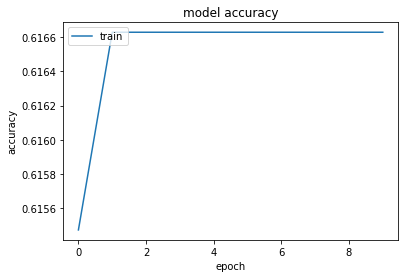

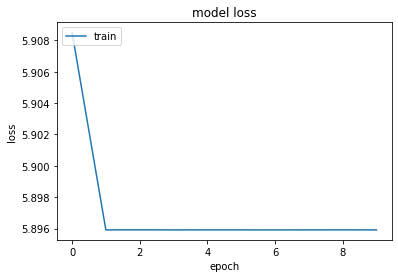

In [40]:
print(score)
print('Finished at {}, saving the results as graphs.'.format(datetime.datetime.now()))

#Accuracy plot
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')

plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
# plt.savefig(save_path + tag + 'model_accuracy' + str(score[1]) + '.pdf')
plt.show()

#Loss plot
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
# plt.savefig(save_path + tag + 'model_loss' + str(score[1]) + '.pdf')
plt.show()